In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# 환경설정

In [2]:
#데이터 로드시 빠르게 로드할 수 있도록 하는 설정변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE=[180,180]

#데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

#변경가능한 값
BATCH_SIZE = 32
EPOCHS = 33

print(ROOT_PATH)

/aiffel/aiffel


# 데이터 준비

In [3]:
#해당 메서드는 주어진 패턴과 일치하는 파일목록을 반환
train_filenames = tf.io.gfile.glob(TRAIN_PATH) 
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
#validation갯수가 전체의 0.3%로 너무 적으므로 train에서 더 가져오려함
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

#모은 filenames를 8:2로 나눔
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
#파일경로에 NORMAL이 있는지 확인하면 정상이미지 확인 가능, 폐렴도 마찬가지
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
#for문 먼저 해석 -> if문 해석 -> 리스트 컴프리헨션 해석 순으로 읽을 것
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
#tf.data는 미니배치로 작업할 수 있도록 해줌 - > 미니배치 작업 밑준비
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
#train, validation 수 확인
#tf.data.experimental.cardinality는 데이터셋의 집합의 수를 리턴
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
#라벨데이터 만들어주는 함수 생성>>> 파일경로 끝에서 두번째 부분 확인하는 방법으로
#os.path.sep은 각 경로를 분리 예:aiffel/data/data1 >>> [aiffel, data, data1]
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   #폐렴이면 True, 노말이면 False

In [10]:
#이미지 형식 변환
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

#이미지 파일의 경로입력 >>> 이미지+라벨 불러옴
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
#train, validation 데이터셋 생성
#num_parallel_calls는 병렬데이터셋을 불러오고 파일여는데 기다리는 시간을 단축
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
#이미지 리사이징, 라벨확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
#test데이터셋도 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분 추가
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터 시각화

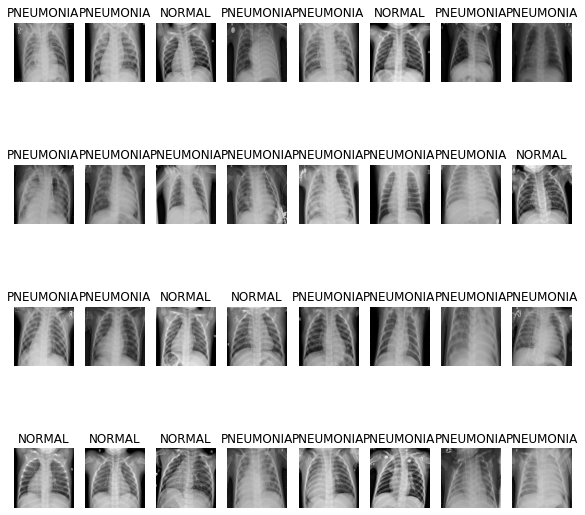

In [15]:
#시각화단계, 이미지 배치 입력시 여러장의 이미지 출력
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1) #ceil메서드는 올림하여 출력할 때 사용
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# CNN모델만들기

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 4, activation='tanh', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='elu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 2, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate=0.3):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block
#배치노멀라이제이션, 드롭아웃은 같이쓰면 성능저하가 일어나지만, 반대의견도 있음

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### data imbalance 해소를위해 Weight balancing 사용 
#### >> 특정 클래스 데이터에 더 큰 loss를 갖도록 가중치를 부여하는 방법

In [19]:
#imbalance해결을 위해 가중치를 달리두는 과정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/33
130/130 [==============================] - 63s 377ms/step - loss: 0.6928 - accuracy: 0.6353 - precision: 0.8514 - recall: 0.6179 - val_loss: 0.5891 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/33
130/130 [==============================] - 49s 382ms/step - loss: 0.3694 - accuracy: 0.8339 - precision: 0.9438 - recall: 0.8256 - val_loss: 0.9718 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 3/33
130/130 [==============================] - 51s 390ms/step - loss: 0.2711 - accuracy: 0.8942 - precision: 0.9663 - recall: 0.8890 - val_loss: 1.0177 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/33
130/130 [==============================] - 52s 403ms/step - loss: 0.2016 - accuracy: 0.9236 - precision: 0.9747 - recall: 0.9212 - val_loss: 1.1469 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/33
130/130 [==============================] - 55s 427ms/step - loss: 0.1833 - accura

# 결과확인

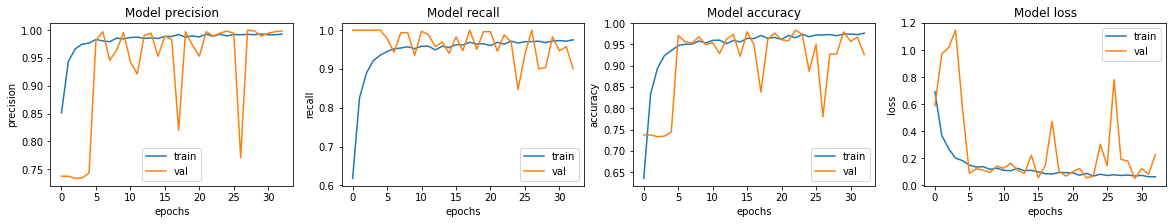

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 219ms/step - loss: 0.3954 - accuracy: 0.8734 - precision: 0.8802 - recall: 0.9231
Loss: 0.3954084813594818,
Accuracy: 0.8733974099159241,
Precision: 0.8801956176757812,
Recall: 0.9230769276618958


# 회고
###### augmentation 방법을 사용했을 때 확실히 효과가 있다는 것이 나타났다. 의료분야에서는 자료를 구하기 어려워서 augmentation의 방법을 사용할 때 높은 성능을 동반한다고 했었는데, 사실그대로였다. 위 방법을 적용하기 이전에는 정확도가 77%였지만, 적용한 후 87%로 약 10%의 성능 향상이 있었다.
###### 결과확인 그래프를 봤을 때 epoch를 더 줄 수 있었다면 더 좋은 결과가 있었으리라고 추측할 수 있다.
###### 배치사이즈를 256으로도 주기도 해봤는데, 73%정도의 정확도가 나왔었다. 배치사이즈를 너무 크게하면 학습을 할 때 앞의 실험을 이어받는 횟수가 적어지기 때문에 낮은 정확도가 나오는 것 같다.
###### dense_block에서 tanh 활성화함수를 써봤지만, 이것도 결과가 좋지는 않았다. 무난하게 relu를 사용하는 것이 최선인 듯 하다.